## **Introduction:**
* This colab is a beta version of the interaction map of intrinsically disordered protein (IMIDP).
* **With a input IDP sequence, this colab will simulate the IDP structural ensemble and create point mutations to change IDP structural preference.**
* This notebook can be used to create IDP biosensors, link IDP structral change with IDP functions and understand IDP intramolecular interactions.

 <b><font color='#FA003F'>The simulation engine in this notebook is the code and CALVADOS force fieled from Kresten Lindorff-Larsen Group and their Google Colab.</b></font> https://github.com/KULL-Centre/CALVADOS

## **Preliminary information:**

This Colab notebook enables running molecular dynamics (MD) simulations of intrinsically disordered proteins (IDPs) and protein regions (IDRs) and to study their conformational ensembles.

MD simulations employ the coarse-grained force field CALVADOS2, where each residue is mapped onto a single bead and modeled with a stickiness parameter and electrostatics.

Simulations only require that the user provides the sequence of an IDP, set environmental conditions (temperature & ionic strength), and the charge states of His residues and terminal amino and carboxyl groups.

<b><font color='#FA003F'>Please note:</font></b> Cells for preliminary operations should be executed one by one to prevent crashes. This notebook uses condacolab, whose installation will cause a kernel restart. Because of this, a crash will happen during preliminary operations if you execute all cells at once.

<b><font color='#FA003F'>How to cite IDRLab:</font></b> If you use IDRLab, we ask you to cite Tesei, Trolle et al. [1]. In addition, you may consider citing Tesei & Lindorff-Larsen [2] for CALVADOS 2 and Eastman et al. [3] for OpenMM.
1. G. Tesei, A. I. Trolle, N. Jonsson, J. Betz, F. E. Knudsen, F. Pesce, K. E. Johansson, K. Lindorff-Larsen __Conformational ensembles of the human intrinsically disordered proteome__ _Nature._ 2024 626:897–904 2023.05.08.539815 DOI: https://doi.org/10.1038/s41586-023-07004-5

2. G. Tesei and K. Lindorff-Larsen __Improved predictions of phase behaviour of intrinsically disordered proteins by tuning the interaction range [version 2; peer review: 2 approved]__ _Open Research Europe_ 2023 2(94) DOI: https://doi.org/10.12688/openreseurope.14967.2
3. P. Eastman, J. Swails, J. D. Chodera et al. __OpenMM 7: Rapid development of high performance algorithms for molecular dynamics__ _PLoS Computational Biology_ 2017 13(7):e1005659 DOI: https://doi.org/10.1371/journal.pcbi.1005659
---


**Binder Note:** The Binder environment already provides a conda environment. No need to install condacolab or run Colab-specific setup. All dependencies are installed from requirements.txt.

In [ ]:
!mamba install -y matplotlib mdtraj openmm=8.2 localcider==0.1.18 -c  conda-forge --yes

In [ ]:
#@title <b>Preliminary operations</b>: setting the environment (ii)
import os
import shutil
import itertools
import numpy as np
import pandas as pd
import scipy.stats as scs
from scipy.optimize import curve_fit
from sklearn.covariance import LedoitWolf
from scipy import constants
from numpy import linalg
from localcider.sequenceParameters import SequenceParameters
import mdtraj as md
import openmm
from openmm import unit, app
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'svg')
# Download required scripts if not present
import wget
if not os.path.exists('block_tools.py'):
if not os.path.exists('main.py'):
from main import BlockAnalysis

In [ ]:
#@title <b>Input a IDP sequence</b>
#MEEPQSDPSVEPPLSQETFSDLWKLLPENNVLSPLPSQAMDDLMLSPDDIEQWFTEDPGPD
#p53
sequence="DDDDDDDEEEEEEEDDDEEEDDEEDEDEDEGEFFEWGEWWFEWFGWEGWWFWG" #@param {type:"string"}
name="DP00719" #@param {type:"string"}

In [13]:
#@title <b><font color='#A79AB2'>MD Toolbox</font></b>
url = 'https://github.com/KULL-Centre/_2023_Tesei_IDRome/blob/main'
# wget.download(url+'/md_simulations/data/residues.csv?raw=true')
# Added -v to the curl command to show more output
!curl -v -O {url+'/md_simulations/data/residues.csv?raw=true'}
# Rename the downloaded file
!mv residues.csv?raw=true residues.csv

residues = pd.read_csv('residues.csv')
residues = residues.set_index('one')

def genParamsLJ(df,seq,Nc,Cc):
    fasta = seq.copy()
    r = df.copy()
    if Nc == 1:
        r.loc['X'] = r.loc[fasta[0]]
        r.loc['X','MW'] += 2
    if Cc == 1:
        r.loc['Z'] = r.loc[fasta[-1]]
        r.loc['Z','MW'] += 16
    lj_eps = 0.2*4.184
    lj_sigma = pd.DataFrame((r.sigmas.values+r.sigmas.values.reshape(-1,1))/2,
                            index=r.sigmas.index,columns=r.sigmas.index)
    lj_lambda = pd.DataFrame((r.lambdas.values+r.lambdas.values.reshape(-1,1))/2,
                             index=r.lambdas.index,columns=r.lambdas.index)
    return lj_eps, lj_sigma, lj_lambda

def genParamsDH(df,seq,temp,ionic,Nc,Cc,Hc):
    kT = 8.3145*temp*1e-3
    fasta = seq.copy()
    r = df.copy()
    # Set the charge on HIS based on the pH of the protein solution
    r.loc['H','q'] = Hc
    if Nc == 1:
        r.loc['X'] = r.loc[fasta[0]]
        r.loc['X','q'] = r.loc[seq[0],'q'] + 1.
        fasta[0] = 'X'
    if Cc == 1:
        r.loc['Z'] = r.loc[fasta[-1]]
        r.loc['Z','q'] = r.loc[seq[-1],'q'] - 1.
        fasta[-1] = 'Z'
    # Calculate the prefactor for the Yukawa potential
    fepsw = lambda T : 5321/T+233.76-0.9297*T+0.1417*1e-2*T*T-0.8292*1e-6*T**3
    epsw = fepsw(temp)
    lB = 1.6021766**2/(4*np.pi*8.854188*epsw)*6.022*1000/kT
    yukawa_eps = [r.loc[a].q*np.sqrt(lB*kT) for a in fasta]
    # Calculate the inverse of the Debye length
    yukawa_kappa = np.sqrt(8*np.pi*lB*ionic*6.022/10)
    return yukawa_eps, yukawa_kappa

def genDCD(name, seq, eqsteps=10):
    """
    Generates coordinate and trajectory
    in convenient formats
    """
    traj = md.load("{:s}/pretraj.dcd".format(name), top="{:s}/top.pdb".format(name))
    cgtop = md.Topology()
    cgchain = cgtop.add_chain()
    for aa in seq:
        cgres = cgtop.add_residue(aa, cgres)
        cgtop.add_atom('CA', element=md.element.carbon, residue=cgres)
    for i in range(traj.n_atoms-1):
        cgtop.add_bond(cgtop.atom(i),cgtop.atom(i+1))
    traj = md.Trajectory(traj.xyz, cgtop, traj.time, traj.unitcell_lengths, traj.unitcell_angles)
    traj = traj.image_molecules(inplace=False, anchor_molecules=[set(traj.top.chain(0).atoms)], make_whole=True)
    traj.center_coordinates()
    traj.xyz += traj.unitcell_lengths[0,0]/2
    traj[int(eqsteps):].save_dcd("{:s}/traj.dcd".format(name))
    traj[int(eqsteps)].save_pdb("{:s}/top.pdb".format(name))

def simulate(residues,name,seq,temp,ionic,Nc,Cc,Hc,nsteps,stride=1e3,eqsteps=1000):
    os.mkdir(name)

    lj_eps, _, _ = genParamsLJ(residues,seq,Nc,Cc)
    yukawa_eps, yukawa_kappa = genParamsDH(residues,seq,temp,ionic,Nc,Cc,Hc)

    N = len(seq)
    L = (N-1)*0.38+4

    system = openmm.System()

    # set box vectors
    a = unit.Quantity(np.zeros([3]), unit.nanometers)
    a[0] = L * unit.nanometers
    b = unit.Quantity(np.zeros([3]), unit.nanometers)
    b[1] = L * unit.nanometers
    c = unit.Quantity(np.zeros([3]), unit.nanometers)
    c[2] = L * unit.nanometers
    system.setDefaultPeriodicBoxVectors(a, b, c)

    top = md.Topology()
    pos = []
    chain = top.add_chain()
    pos.append([[0,0,L/2+(i-N/2.)*.38] for i in range(N)])
    for resname in seq:
        residue = top.add_residue(resname, chain)
        top.add_atom(resname, element=md.element.carbon, residue=residue)
    for i in range(chain.n_atoms-1):
        top.add_bond(chain.atom(i),chain.atom(i+1))
    md.Trajectory(np.array(pos).reshape(N,3), top, 0, [L,L,L], [90,90,90]).save_pdb('{:s}/top.pdb'.format(name))

    pdb = app.pdbfile.PDBFile('{:s}/top.pdb'.format(name))

    system.addParticle((residues.loc[seq[0]].MW+2)*unit.amu)
    for a in seq[1:-1]:
        system.addParticle(residues.loc[a].MW*unit.amu)
    system.addParticle((residues.loc[seq[-1]].MW+16)*unit.amu)

    hb = openmm.openmm.HarmonicBondForce()
    energy_expression = 'select(step(r-2^(1/6)*s),4*eps*l*((s/r)^12-(s/r)^6-shift),4*eps*((s/r)^12-(s/r)^6-l*shift)+eps*(1-l))'
    ah = openmm.openmm.CustomNonbondedForce(energy_expression+'; s=0.5*(s1+s2); l=0.5*(l1+l2); shift=(0.5*(s1+s2)/2)^12-(0.5*(s1+s2)/2)^6')
    yu = openmm.openmm.CustomNonbondedForce('q*(exp(-kappa*r)/r - exp(-kappa*4)/4); q=q1*q2')
    yu.addGlobalParameter('kappa',yukawa_kappa/unit.nanometer)
    yu.addPerParticleParameter('q')

    ah.addGlobalParameter('eps',lj_eps*unit.kilojoules_per_mole)
    ah.addPerParticleParameter('s')
    ah.addPerParticleParameter('l')

    for a,e in zip(seq,yukawa_eps):
        yu.addParticle([e*unit.nanometer*unit.kilojoules_per_mole])
        ah.addParticle([residues.loc[a].sigmas*unit.nanometer, residues.loc[a].lambdas*unit.dimensionless])

    for i in range(N-1):
        hb.addBond(i, i+1, 0.38*unit.nanometer, 8033*unit.kilojoules_per_mole/(unit.nanometer**2))
        yu.addExclusion(i, i+1)
        ah.addExclusion(i, i+1)

    yu.setForceGroup(0)
    ah.setForceGroup(1)
    yu.setNonbondedMethod(openmm.openmm.CustomNonbondedForce.CutoffPeriodic)
    ah.setNonbondedMethod(openmm.openmm.CustomNonbondedForce.CutoffPeriodic)
    hb.setUsesPeriodicBoundaryConditions(True)
    yu.setCutoffDistance(4*unit.nanometer)
    ah.setCutoffDistance(2*unit.nanometer)

    system.addForce(hb)
    system.addForce(yu)
    system.addForce(ah)

    #serialized_system = XmlSerializer.serialize(system)
    #outfile = open('system.xml','w')
    #outfile.write(serialized_system)
    #outfile.close()

    integrator = openmm.openmm.LangevinIntegrator(temp*unit.kelvin,0.01/unit.picosecond,0.010*unit.picosecond) #10 fs timestep

    platform = openmm.Platform.getPlatformByName('CUDA')

    simulation = app.simulation.Simulation(pdb.topology, system, integrator, platform, dict(CudaPrecision='mixed'))

    check_point = '{:s}/restart.chk'.format(name)

    if os.path.isfile(check_point):
        print('Reading check point file')
        simulation.loadCheckpoint(check_point)
        simulation.reporters.append(app.dcdreporter.DCDReporter('{:s}/pretraj.dcd'.format(name),int(stride),append=True))
    else:
        simulation.context.setPositions(pdb.positions)
        simulation.minimizeEnergy()
        simulation.reporters.append(app.dcdreporter.DCDReporter('{:s}/pretraj.dcd'.format(name),int(stride)))

    simulation.reporters.append(app.statedatareporter.StateDataReporter('{:s}/traj.log'.format(name),int(stride),
             potentialEnergy=True,temperature=True,step=True,speed=True,elapsedTime=True,separator='\t'))

    simulation.step(nsteps)

    simulation.saveCheckpoint(check_point)

    genDCD(name,[residues.three[aa] for aa in seq],eqsteps)

curl: /usr/local/lib/libcurl.so.4: no version information available (required by curl)
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0* Host github.com:443 was resolved.
* IPv6: (none)
* IPv4: 140.82.114.4
*   Trying 140.82.114.4:443...
* ALPN: curl offers h2,http/1.1
} [5 bytes data]
* TLSv1.3 (OUT), TLS handshake, Client hello (1):
} [512 bytes data]
*  CAfile: /usr/local/ssl/cacert.pem
*  CApath: none
{ [5 bytes data]
* TLSv1.3 (IN), TLS handshake, Server hello (2):
{ [122 bytes data]
* TLSv1.3 (IN), TLS change cipher, Change cipher spec (1):
{ [1 bytes data]
* TLSv1.3 (IN), TLS handshake, Encrypted Extensions (8):
{ [19 bytes data]
* TLSv1.3 (IN), TLS handshake, Certificate (11):
{ [3135 bytes data]
* TLSv1.3 (IN), TLS handshake, CERT verify (15):
{ [79 bytes data]
* TLSv1.3 (IN), TLS handshake, 

EmptyDataError: No columns to parse from file

In [ ]:
#@title <b><font color='#45B69C'>3.1 - Run MD simulation</font></b>
#@markdown Simulation time (ns):
Simulation_time = "AUTO" #@param {type:"raw"}

N_res = len(sequence)
N_save = 7000 if N_res < 150 else int(np.ceil(3e-4*N_res**2)*1000)

if Simulation_time == "AUTO":
    nsteps = 1010*N_save
    print('AUTO simulation length selected. Running for {} ns'.format(nsteps*0.01/1000))
else:
    nsteps = float(Simulation_time)*1000/0.01//N_save*N_save
try:
    shutil.rmtree(name)
except:
    pass
simulate(residues,name,list(sequence),temp=310,ionic=0.15,Nc=1,Cc=1,
         Hc=0,nsteps=nsteps,stride=N_save,eqsteps=10)

AUTO simulation length selected. Running for 70.7 ns


In [ ]:
#@title <b>Preprocess Interaction Map</b>

class ContactProbData:
    def __init__(self, name, cutoff, traj):
        # Contact name include different information
        self.name = name
        # Cutoff distance for determining the contact
        self.cutoff = cutoff

        self.contact = self.compute_contact(traj)

    # Define a function to calculate contact probability
    def compute_contact(self, traj):
        # Calculate contact map using the MDtraj library. Cont stored the distance between two residues.
        # The scheme 'CA' and ignore_nonprotein removed ions and ACE NME caps
        indices = traj.top.select_pairs('all', 'all')
        [cont, pairs] = md.compute_contacts(traj, indices)
        # Determine whether the distance is smaller than the cutoff.
        contact = (cont < self.cutoff)
        # Calculate the average contact frequency of each residue pair
        cont_mean = contact.mean(0)
        cont_df = pd.DataFrame({'r_1': pairs[:, 0]+1, 'r_2': pairs[:, 1]+1, 'cont_prob': cont_mean[:]})
        cont_df['r_1']=cont_df['r_1'].astype('int')
        cont_df['r_2'] = cont_df['r_2'].astype('int')
        cont_df['distance'] = cont_df['r_2'] - cont_df['r_1']
        # Free up the memory
        del contact
        del pairs
        return cont_df

def generate_contact(protein_name, pdb_top='__START_0.pdb', xtc_input=5, cutoff=1.2):
    traj = md.load(xtc_input, top=pdb_top)
    contact = ContactProbData(protein_name, cutoff, traj)
    return contact

# fitting function of standard contact probability map.
# The fitting_function or the calculation of the fitting should be computed in a seperate file
def fitting_function(df, a, b):
    """

    :param df: interaction data
    :type df: dataframe
    :return: int, fitting result
    """
    return a * df['distance'] ** b


# Use standard contact probability curve to calculate interaction strength
def normalization(target_map, a1=13.12, b1=-2.32, inter_cutoff=(2, 1, -1, -2), value_list=(2, 1, 0, -1, -2)):
    """

    :param target_map: interaction data
    :type target_map: dataframe
    :param a1:
    :param b1:
    :param inter_cutoff: interaction strength cutoff
    :type inter_cutoff: list
    :param value_list: interaction strength (corresponding to the inter_cutoff)
    :type value_list: list
    :return:
    """
    # Create an empty array for calculating interaction.
    # (Interaction is the binary value representing the interaction type
    # Relative_Strength is the ratio between pairwise contact probability and standard curve)
    target_map['gs_standard'] = target_map.apply(fitting_function, axis=1 ,args=(a1, b1))
    target_map['relative_strength'] = np.where(target_map['cont_prob'] == 0, 0,
                                               np.log(target_map['cont_prob'] / target_map['gs_standard']))
    col = 'relative_strength'
    choice_list = value_list
    condition = [target_map[col] >= inter_cutoff[0],
                 (target_map[col] >= inter_cutoff[1]) & (target_map[col] < inter_cutoff[0]),
                 (target_map[col] < inter_cutoff[1]) & (target_map[col] > inter_cutoff[2]),
                 (target_map[col] <= inter_cutoff[2]) & (target_map[col] > inter_cutoff[3]),
                 (target_map[col] <= inter_cutoff[3])
                 ]
    target_map['plot_value'] = np.select(condition, choice_list, default=0)
    return target_map


In [ ]:
#@title <b> Calculate Interaction Intensities </b>
contact = generate_contact(name, os.path.join(os.getcwd(),name,"top.pdb"), os.path.join(os.getcwd(),name,"traj.dcd"))
# Tracking the running status for debugging
# Calculate interaction type based on ideal polymer model
interaction = normalization(contact.contact)
# Save the interaction map's raw value into the csv file for backup
interaction.to_csv(os.path.join(os.getcwd(), name , "colab.csv"))

/usr/local/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
#@title <b> Preset Plotting Functions </b>
# Create the networkx graph
#### problem need to be solved: width of the graph
##Check this with the latest graphx library
# Create a  networkx graph object
import networkx as nx
def create_network(seq, length, size=10):
    '''

    :param seq:
    :param length:
    :param size:
    :return:
    '''
    graphg = nx.MultiDiGraph()
    # Add residue node to network graphics
    i = 1
    while i < (length + 1):
        graphg.add_node(i, residue=seq[i - 1], pos=(i, size))
        i += 1
    return graphg


# To help us identify different amino acid. We color code negative charged residues , positive
# charged residues and aromatic residues with different colors.
def seq_color(seq):
    '''

    :param seq:
    :return:
    '''
    # Create empty list
    negacharged = []
    posicharged = []
    aromatic = []
    # Identify special residues and append into corresponding list
    for index, i in enumerate(seq):
        if i in ['D', 'E']:
            negacharged.append(index)
        elif i in ['R', 'K', 'H']:
            posicharged.append(index)
        elif i in ['F', 'Y', 'W']:
            aromatic.append(index)
    return negacharged, posicharged, aromatic


# Produce position matrix and layout.
def create_position(graphg):
    '''

    :param graphg:
    :return:
    '''
    # Get the position and the layout for the networkx nodes
    pos = nx.get_node_attributes(graphg, 'pos')
    layout = dict((n, graphg._node[n]["pos"]) for n in graphg.nodes())
    return pos, layout


# Plot function of sequence color coding
def color_text(pos, index, colorselec, seq, ax):
    '''

    :param pos:
    :param index:
    :param colorselec:
    :param seq:
    :param ax:
    :return:
    '''
    # Get the position of each residue
    (x, y) = pos[index + 1]
    # Get the name of each residue
    label = seq[index]  # this makes "1" and 1 labeled the same
    # Color coding the sequence
    type_dict = {'Y': 'aromatic', 'F': 'aromatic', 'W': 'aromatic',
                 'R': 'positive', 'H': 'positive', 'K': 'positive',
                 'D': 'negative', 'E': 'negative',
                 'S': 'polar', 'T': 'polar', 'Q': 'polar', 'N': 'polar',
                 'A': 'hydrophobic',
                 'V': 'hydrophobic',
                 'I': 'hydrophobic',
                 'L': 'hydrophobic',
                 'M': 'hydrophobic',
                 'C': 'hydrophobic',
                 'G': 'hydrophobic',
                 'P': 'hydrophobic'}
    color_dict = {'aromatic':'yellow','positive':'blue',
                  'negative':'red','polar':'black','hydrophobic':'orange'}
    if not color_dict.get(type_dict[label],0):
        raise ValueError('wrong residue')
    ax.plot(
        x - 0.2,
        y,
        marker='o',
        color=color_dict[type_dict[label]],ms=7,markeredgecolor='black'
    )


# Color coding the residue based on the position matrix and sequence color code.
def create_color_coding(seq, graphg, pos, negacharged, posicharged, aromatic, figuresize=(10, 10), nodesize=0.1):
    '''

    :param seq:
    :param graphg:
    :param pos:
    :param negacharged:
    :param posicharged:
    :param aromatic:
    :param figuresize:
    :param nodesize:
    :return:
    '''
    fig = plt.figure(figsize=figuresize)
    ax = fig.add_subplot(111)
    seqdict = {}
    for index, i in enumerate(seq):
        seqdict[index + 1] = i
    nx.draw(graphg, pos, labels=seqdict, with_labels=False, node_size=nodesize, ax=ax)
    # Set residue color based on their types
    for index, node in enumerate(graphg):
        if index in negacharged:
            color_text(pos, index, 'r', seq, ax)
        elif index in posicharged:
            color_text(pos, index, 'b', seq, ax)
        elif index in aromatic:
            color_text(pos, index, 'orange', seq, ax)
        else:
            color_text(pos, index, 'black', seq, ax)
    return fig, ax


# Plot selected interaction line
def interaction_plotting(interaction, layout, ax, inter_type):
    '''

    :param interaction:
    :param layout:
    :param ax:
    :param intertype:
    :param plot_c:
    :return:
    '''
    if inter_type == 2:
        colorset = 'green'
        connect = "arc3,rad=-0.5"
    if inter_type == 1:
        colorset = 'lightgreen'
        connect = "arc3,rad=-0.5"
    if inter_type == -2:
        colorset = 'red'
        connect = "arc3,rad=0.5"
    if inter_type == -1:
        colorset = 'orange'
        connect = "arc3,rad=0.5"
    # During the debug process, we only consider the condition when plot_c>0.
    if inter_type > 0:
        # full_strength, overall_strength = interaction_strength.calculate_overall_strength(interaction, inter_type)
        full_strength = []
        overall_strength = 1
    else:
        full_strength = []
        overall_strength = -1
    select_df=interaction[(interaction['plot_value'] == inter_type)&
                          (interaction['distance']>4)]
    for index, data in select_df.iterrows():
        strength = data['cont_prob']
        rela_strength = data['relative_strength']
        distance = data['distance']
        r1 = data['r_1']
        r2 = data['r_2']
        if inter_type > 0:
            #    linewidth = raw_value_new[index]
            linewidth = 4 * strength * (1 + rela_strength)
            distance = data['distance']
        else:
            #    linewidth = -1 * raw_value_new[index]
            linewidth = -4 * strength * (rela_strength-1)
        # Adjust location to improve visualization effect
        a = layout[r1][0] - 0.2
        b = layout[r1][1]
        c = layout[r2][0] + 0.2
        d = layout[r2][1]
        # Plot Interaction between pairs
        ax.annotate("",
                    xy=(a, b),
                    xytext=(c, d),
                    arrowprops=dict(arrowstyle="-", color=colorset,
                                    shrinkA=10, shrinkB=10, lw=linewidth,
                                    patchA=None, patchB=None,
                                    connectionstyle=connect,
                                    ), )
    return overall_strength


def interaction_map(seq, length, interaction, figname):
    # Create network object
    graphg = create_network(seq, length)
    # Obtain position list
    (pos, layout) = create_position(graphg)
    # Color coding different residues
    (negacharged, posicharged, aromatic) = seq_color(seq)
    (fig, ax) = create_color_coding(seq, graphg, pos, negacharged, posicharged, aromatic)
    # Plot interaction between each residue
    att1 = interaction_plotting(interaction, layout, ax, 1)
    att2 = interaction_plotting(interaction, layout, ax, 2)
    rep1 = interaction_plotting(interaction, layout, ax,  -1)
    rep2 = interaction_plotting(interaction, layout, ax,  -2)
    graphg.add_edge(1, 5)
    # Save the plot to png file
    plt.savefig(figname + '.png')
    plt.savefig(figname + '.svg')
    # Show the plot
    plt.show()
    # Return the interaction strength

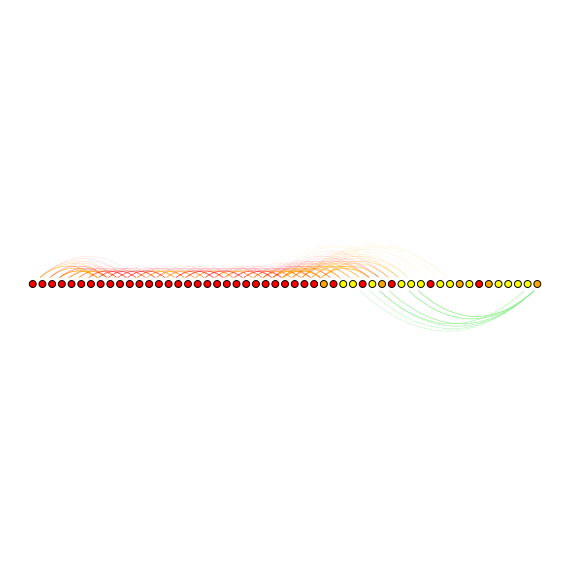

In [ ]:
#@title <b> Plot the Interaction Map </b>
interaction_map(sequence, N_res, interaction, name)
# @markdown ---
# @markdown Green curves are attractive interactions between residues.

# @markdown Red curves are repulsive interactions between residues.

# @markdown Line width is propotional to the interaction strength.

# @markdown Residue types are color coded.

In [ ]:
#@title <b> Add residue informations to the interaction map </b>
# Loading interaction map to a seperate variable name.
df=interaction
# The interaction map is based on residue index
# Map residue index to 1-letter amino acid representations
seq_ref_dic=dict(zip(range(1,N_res+1),list(sequence)))
df['r_1_res']=df['r_1'].map(seq_ref_dic)
df['r_2_res']=df['r_2'].map(seq_ref_dic)
# Map residue type information to the data frame.
import wget
if not os.path.exists('residue_info.csv'):
residue_info=pd.read_csv('residue_info.csv')
type_dict=residue_info.set_index('residue').to_dict()['residue_type']
df['r_1_type']=df['r_1_res'].map(type_dict)
df['r_2_type']=df['r_2_res'].map(type_dict)

Text(0.5, 0, 'relative interaction strength')

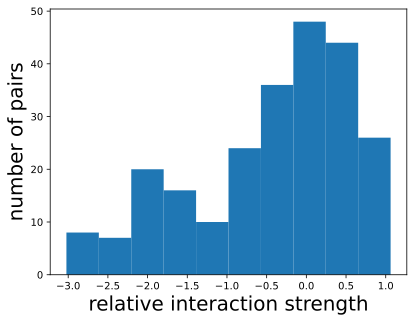

In [ ]:
#@title <b> Filter out weak interactions and short range interactions </b>
# Filter out short range interactions, low contact probability interactions or terminal interactions
contact_probability_cutoff=0.01 # @param {type:"slider", min:0, max:0.1, step:0.001}
distance_cutoff=5 # @param {type:"slider", min:1, max:10, step:1}

# Filter out short range interactions, low contact probability interactions or terminal interactions
selected_raw=df[(df['cont_prob']>=contact_probability_cutoff)
            & (df['distance']>=distance_cutoff)
            & ~(df['r_1']==1)
            & ~(df['r_2']==N_res)]
# Plot a histgram for visulizing the interaction strength distribution.
selected_raw=selected_raw.sort_values(by='relative_strength', ascending=False)
plt.hist(selected_raw['relative_strength'])
plt.ylabel('number of pairs',fontsize=20)
plt.xlabel('relative interaction strength',fontsize=20)

In [ ]:
#@title <b> Discover residue motifs/chunks driving the interactions </b>
# Here we define a chunk as three adjacent amino acid residues.
# We will calculate the overall interaction strength between two chunks.
# There are 3x3 interactions in each chunk pairs.
# Different weight will be assigned to those interactions based on the distance between them with the center residue.
def calc_chunk_strength(row,selected_raw):
    left=row['r_1']
    right=row['r_2']
    chunk_strength=0
    count=0
    for i in row['r_1_chunk_index']:
        for j in row['r_2_chunk_index']:
            strength_distance = abs(i-left)+abs(j-right)
            if not selected_raw[(selected_raw['r_1']==i)&(selected_raw['r_2']==j)]['relative_strength'].empty:
                chunk_strength+=selected_raw[(selected_raw['r_1']==i)&(selected_raw['r_2']==j)]['relative_strength'].values[0]/2**(strength_distance)
    return chunk_strength
selected_raw['r_1_chunk_index']=selected_raw['r_1'].apply(lambda x: [x-1,x,x+1])
selected_raw['r_2_chunk_index']=selected_raw['r_2'].apply(lambda x: [x-1,x,x+1])
selected_raw['r_1_chunk']=selected_raw['r_1'].apply(lambda x: sequence[x-1-1:x+1-1+1])
selected_raw['r_2_chunk']=selected_raw['r_2'].apply(lambda x: sequence[x-1-1:x+1-1+1])
for index, row in selected_raw.iterrows():
    left_chunk=row['r_1_chunk_index']
    right_chunk=row['r_2_chunk_index']
    chunk_strength=calc_chunk_strength(row,selected_raw)
    selected_raw.loc[index,'chunk_strength']=chunk_strength

In [ ]:
#@title <b>  Hydrophobicity or charge status of residue chunks </b>
# We create mutations based on hydrophobicity or charge status of chunks.
# Map hydrophobicity scale for each chunk.
# The hydrophobicity scale is Kyte-Doolittle
import wget
if not os.path.exists('hydrophobicity.csv'):
hydro_scale=pd.read_csv('hydrophobicity.csv')
hydro_scale
hydro_dict=dict(zip(hydro_scale['aa'].to_list(),hydro_scale['Kyte-Doolittle'].to_list()))
def hydro_search(df_r_1):
    k=0
    for i in df_r_1:
        k+=hydro_dict[i]
    return k
selected_raw['r_1_hydro']=selected_raw['r_1_chunk'].apply(hydro_search)
selected_raw['r_2_hydro']=selected_raw['r_2_chunk'].apply(hydro_search)
# charge status of the chunk
charge_dict={}
for key, i in type_dict.items():
    if i=='positive':
        charge_dict[key]=1
    elif i=='negative':
        charge_dict[key]=-1
    else:
        charge_dict[key]=0
def charge_search(df_r_1):
    k=0
    for i in df_r_1:
        k+=charge_dict[i]
    return k
selected_raw['r_1_charge']=selected_raw['r_1_chunk'].apply(charge_search)
selected_raw['r_2_charge']=selected_raw['r_2_chunk'].apply(charge_search)
# number of aromatic residues in the chunk
aromatic_dict={}
for key, i in type_dict.items():
    if i=='aromatic':
        aromatic_dict[key]=1
    else:
        aromatic_dict[key]=0
def aromatic_search(df_r_1):
    k=0
    for i in df_r_1:
        k+=aromatic_dict[i]
    return k
selected_raw['r_1_aromatic']=selected_raw['r_1_chunk'].apply(aromatic_search)
selected_raw['r_2_aromatic']=selected_raw['r_2_chunk'].apply(aromatic_search)
selected=selected_raw.copy(deep=True)

In [ ]:
#@title <b> Select interaction types</b>
interaction_type='attractive' # @param ["repulsive","attractive"] {type:"string"}
if interaction_type=='repulsive':
    selected=selected[selected['plot_value']<0]
elif interaction_type=='attractive':
    selected=selected[selected['plot_value']>0]




In [ ]:
#@title <b> Select mutation types (select the residue type for the corresponding interaction type)</b>
# @markdown ---
# @markdown ### For repulsive interactions:
if interaction_type=='repulsive':
  residue_types='charge' # @param ["charge", "hydrophilic"] {type:"string"}
# @markdown ---
# @markdown ### For attractive interactions:
elif interaction_type=='attractive':
  residue_types='aromatic' # @param ["charge","aromatic", "hydrophobic"] {type:"string"}

In [ ]:
#@title <b> Filteration based on residue types and interaction types
# @markdown ### Cutoff of hydrophobic chunks and hydrophilic chunks
# @markdown Kyte-Doolittle-Hydropathy scale. Default value is defined by Glycine
hydrophobicity_cutoff=-1.2 #@param {type:"number"}
if residue_types=='charge' and interaction_type=='repulsive':
    selected=selected[(selected['r_1_charge']*selected['r_2_charge']>0)].sort_values(by=['chunk_strength'],ascending=True)
elif residue_types=='charge' and interaction_type=='attractive':
    selected=selected[(selected['r_1_charge']*selected['r_2_charge']<0)].sort_values(by=['chunk_strength'],ascending=False)
elif residue_types=='aromatic':
    selected=selected[(selected['r_1_aromatic']*selected['r_2_aromatic']>0)].sort_values(by=['chunk_strength'],ascending=False)
elif residue_types=='hydrophobic':
    selected=selected[((selected['r_1_hydro']-hydrophobicity_cutoff)
    *(selected['r_2_hydro']-hydrophobicity_cutoff)>0)]
    selected=selected[(selected['r_1_hydro']-hydrophobicity_cutoff)<0].sort_values(by=['chunk_strength'],ascending=False)
elif residue_types=='hydrophilic':
    selected=selected[((selected['r_1_hydro']-hydrophobicity_cutoff)
    *(selected['r_2_hydro']-hydrophobicity_cutoff)>0)]
    selected=selected[(selected['r_1_hydro']-hydrophobicity_cutoff)>0].sort_values(by=['chunk_strength'],ascending=True)
else:
    raise ValueError("Wrong combinations (Wait for me to introduce more interaction types)")

In [ ]:
selected

,r_1,r_2,cont_prob,distance,gs_standard,relative_strength,plot_value,r_1_res,r_2_res,r_1_type,...,r_2_chunk_index,r_1_chunk,r_2_chunk,chunk_strength,r_1_hydro,r_2_hydro,r_1_charge,r_2_charge,r_1_aromatic,r_2_aromatic
1240,36,52,0.061,16,0.021105,1.061387,1,W,W,aromatic,...,"[51, 52, 53]",EWG,FWG,3.000097,-4.8,1.5,-1,0,1,2


In [ ]:
#@title <b> Mutation Scanning Algorithms
def detect_target_residues(interaction_type,residue_types):
  #Charge Repulsive Interactions
  #Charge Attractive Interactions
  #Aromatic Attractive Interactions
  #Hydrophobic Attractive Interactions
  if interaction_type=='repulsive':

def single_mutation(selected,number_of_mutations,interaction_type,residue_types):
  all_seq_single=[]
  seq_name_v1=[]
  for i in selected['r_1'].unique():
      wt_seq=list(sequence)
      print(seq_ref_dic[i],type_dict[seq_ref_dic[i]])
      if
          seq_name='p53_'+''.join([seq_ref_dic[i],str(i),'E'])
          wt_seq[i-1]='E'
      else:
          seq_name='p53_'+''.join([seq_ref_dic[i],str(i),'W'])
          wt_seq[i-1]='W'
      seq_name_v1.append(seq_name)
      all_seq_v1.append("".join(wt_seq))
  zipped_v1=dict(zip(seq_name_v1,all_seq_v1))
  seq_df_v1=pd.DataFrame.from_dict(zipped_v1,orient='index').reset_index()
  return seq_df_v1




IndentationError: expected an indented block after 'if' statement on line 7 (ipython-input-3587728103.py, line 9)

In [ ]:
def single_mutation(selected,number_of_mutations,interaction_type,residue_types):
  all_seq_v1=[]
  seq_name_v1=[]
  for i in selected['r_1'].unique():
      wt_seq=list(sequence)
      print(seq_ref_dic[i],type_dict[seq_ref_dic[i]])
      if
          seq_name='p53_'+''.join([seq_ref_dic[i],str(i),'E'])
          wt_seq[i-1]='E'
      else:
          seq_name='p53_'+''.join([seq_ref_dic[i],str(i),'W'])
          wt_seq[i-1]='W'
      seq_name_v1.append(seq_name)
      all_seq_v1.append("".join(wt_seq))
  return seq_df_v1

In [ ]:
#@title <b> Create and Save mutant sequences to csv file
# @markdown Number of mutations introduced on a single sequence.

# @markdown (There may not be enough mutants for a given residue type).
number_of_sequences=100 #@param {type:"number"}

if number_of_mutations==1:
  seq_df=single_mutation(selected)
elif number_of_mutations==2:
  seq_df=two_mutations(selected)
elif number_of_mutations==3:
  seq_df=three_mutations(selected)
else:
  raise ValueError("Wrong number of mutations")
seq_df.to_csv('seq_df_{}_mutations.csv'.format(number_of_mutations),header=False, index=False)

In [ ]:

seq_df_v1.to_csv('seq_df_v1.csv',header=False, index=False)

Q polar
S polar
L hydrophobic
A hydrophobic
K positive
P hydrophobic
L hydrophobic
V hydrophobic
L hydrophobic
L hydrophobic


**Binder Note:** To download results, use the JupyterLab file browser to right-click and download files, or use Python's standard file I/O. The Colab-specific files.download is not available.